## Setup



In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 37.7 MB/s 
     |████████████████████████████████| 596 kB 43.8 MB/s 
     |████████████████████████████████| 6.6 MB 39.2 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint


## Configuration

In [ ]:
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 512
epochs = 8

PATIENCE = 4

callbacks = [EarlyStopping(patience=PATIENCE), ModelCheckpoint(filepath='/content/drive/MyDrive/NLP_project/models/bert_snli.h5', save_best_only=True, save_weights_only=True)]

# Labels in our dataset.
labels = ["contradiction", "entailment", "neutral"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the Data

In [ ]:
!curl -LO https://raw.githubusercontent.com/MohamadMerchant/SNLI/master/data.tar.gz
!tar -xvzf data.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.1M  100 11.1M    0     0  25.1M      0 --:--:-- --:--:-- --:--:-- 25.0M
SNLI_Corpus/
SNLI_Corpus/snli_1.0_dev.csv
SNLI_Corpus/snli_1.0_train.csv
SNLI_Corpus/snli_1.0_test.csv


In [ ]:
# There are more than 550k samples in total; we will use 100k for this example.
train_df = pd.read_csv("SNLI_Corpus/snli_1.0_train.csv", nrows=100000)
valid_df = pd.read_csv("SNLI_Corpus/snli_1.0_dev.csv")
test_df = pd.read_csv("SNLI_Corpus/snli_1.0_test.csv")

# Shape of the data
print(f"Total train samples : {train_df.shape[0]}")
print(f"Total validation samples: {valid_df.shape[0]}")
print(f"Total test samples: {valid_df.shape[0]}")

Total train samples : 100000
Total validation samples: 10000
Total test samples: 10000


Dataset Overview:

- sentence1: The premise caption that was supplied to the author of the pair.
- sentence2: The hypothesis caption that was written by the author of the pair.
- similarity: This is the label chosen by the majority of annotators.
Where no majority exists, the label "-" is used (we will skip such samples here).

Here are the "similarity" label values in our dataset:

- Contradiction: The sentences share no similarity, have contrasting meanings
- Entailment: The premise entails the hypothesis
- Neutral: The sentences are neutral, no entailment can be recognized

Let's look at one sample from the dataset:

In [ ]:
print(f"Sentence1: {train_df.loc[1, 'sentence1']}")
print(f"Sentence2: {train_df.loc[1, 'sentence2']}")
print(f"Similarity: {train_df.loc[1, 'similarity']}")

Sentence1: A person on a horse jumps over a broken down airplane.
Sentence2: A person is at a diner, ordering an omelette.
Similarity: contradiction


## Preprocessing

In [ ]:
# We have some NaN entries in our train data, we will simply drop them.
print("Number of missing values")
print(train_df.isnull().sum())
train_df.dropna(axis=0, inplace=True)

Number of missing values
similarity    0
sentence1     0
sentence2     3
dtype: int64


Distribution of our training targets.

In [ ]:
print("Train Target Distribution")
print(train_df.similarity.value_counts())

Train Target Distribution
entailment       33384
contradiction    33310
neutral          33193
-                  110
Name: similarity, dtype: int64


Distribution of our validation targets.

In [ ]:
print("Validation Target Distribution")
print(valid_df.similarity.value_counts())

Validation Target Distribution
entailment       3329
contradiction    3278
neutral          3235
-                 158
Name: similarity, dtype: int64


The value "-" appears as part of our training and validation targets.
We will skip these samples.

In [ ]:
train_df = (
    train_df[train_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)
valid_df = (
    valid_df[valid_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)


One-hot encode training, validation, and test labels.

In [ ]:
train_df["label"] = train_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=3)

valid_df["label"] = valid_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_val = tf.keras.utils.to_categorical(valid_df.label, num_classes=3)

test_df["label"] = test_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=3)

## Keras Custom Data Generator

In [ ]:

class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)


## Build the model.

In [ ]:
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

    # BERT tokenizer outputs encoded tokenids
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )

    # Attention masks layer to focus on tokens
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )

    # Token type ids to identify different sequences
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    bert_model.trainable = False

    bert_output = bert_model(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output

    # Training BiLSTM ontop of pre-existing model to finetune parameters better for our task
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(sequence_output)


    # Applying hybrid pooling approach the bi-lstm layer
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(3, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7fc7a75f2590>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                           

Create train and validation data generators

In [ ]:
train_data = BertSemanticDataGenerator(
    train_df[["sentence1", "sentence2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    valid_df[["sentence1", "sentence2"]].values.astype("str"),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

## Train the Model

Training is done only for the top layers to perform "feature extraction",
which will allow the model to use the representations of the pretrained model.

In [ ]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    callbacks = callbacks,
    workers=-1,
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch 1/8
  1/390 [..............................] - ETA: 28:51 - loss: 0.9710 - acc: 0.5469

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  5/390 [..............................] - ETA: 26:22 - loss: 0.9859 - acc: 0.5086

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  8/390 [..............................] - ETA: 26:15 - loss: 0.9750 - acc: 0.5234

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  9/390 [..............................] - ETA: 26:12 - loss: 0.9767 - acc: 0.5234

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 18/390 [>.............................] - ETA: 25:35 - loss: 0.9652 - acc: 0.5360

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 35/390 [=>............................] - ETA: 24:23 - loss: 0.9392 - acc: 0.5575

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 37/390 [=>............................] - ETA: 24:15 - loss: 0.9378 - acc: 0.5592

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 40/390 [==>...........................] - ETA: 24:02 - loss: 0.9336 - acc: 0.5615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 41/390 [==>...........................] - ETA: 23:58 - loss: 0.9326 - acc: 0.5615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 47/390 [==>...........................] - ETA: 23:33 - loss: 0.9257 - acc: 0.5647

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 53/390 [===>..........................] - ETA: 23:08 - loss: 0.9225 - acc: 0.5662

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 55/390 [===>..........................] - ETA: 23:00 - loss: 0.9215 - acc: 0.5675

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 58/390 [===>..........................] - ETA: 22:47 - loss: 0.9180 - acc: 0.5692

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 62/390 [===>..........................] - ETA: 22:31 - loss: 0.9150 - acc: 0.5713

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 65/390 [====>.........................] - ETA: 22:18 - loss: 0.9123 - acc: 0.5729

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 66/390 [====>.........................] - ETA: 22:14 - loss: 0.9125 - acc: 0.5727

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 72/390 [====>.........................] - ETA: 21:49 - loss: 0.9079 - acc: 0.5777

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 79/390 [=====>........................] - ETA: 21:20 - loss: 0.9041 - acc: 0.5801

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 86/390 [=====>........................] - ETA: 20:51 - loss: 0.9008 - acc: 0.5820

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 87/390 [=====>........................] - ETA: 20:47 - loss: 0.8996 - acc: 0.5829

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


100/390 [======>.......................] - ETA: 19:54 - loss: 0.8879 - acc: 0.5921

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


115/390 [=======>......................] - ETA: 18:52 - loss: 0.8752 - acc: 0.5997

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


116/390 [=======>......................] - ETA: 18:48 - loss: 0.8742 - acc: 0.6002

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


134/390 [=========>....................] - ETA: 17:33 - loss: 0.8623 - acc: 0.6087

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


137/390 [=========>....................] - ETA: 17:21 - loss: 0.8594 - acc: 0.6106

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


147/390 [==========>...................] - ETA: 16:40 - loss: 0.8521 - acc: 0.6153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


152/390 [==========>...................] - ETA: 16:19 - loss: 0.8498 - acc: 0.6166

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


156/390 [===========>..................] - ETA: 16:03 - loss: 0.8465 - acc: 0.6184

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


180/390 [============>.................] - ETA: 14:24 - loss: 0.8328 - acc: 0.6270

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


187/390 [=============>................] - ETA: 13:55 - loss: 0.8280 - acc: 0.6297

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


190/390 [=============>................] - ETA: 13:43 - loss: 0.8264 - acc: 0.6306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


193/390 [=============>................] - ETA: 13:30 - loss: 0.8250 - acc: 0.6315

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


203/390 [==============>...............] - ETA: 12:49 - loss: 0.8203 - acc: 0.6341

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


219/390 [===============>..............] - ETA: 11:43 - loss: 0.8110 - acc: 0.6399

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


224/390 [================>.............] - ETA: 11:23 - loss: 0.8089 - acc: 0.6411

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


225/390 [================>.............] - ETA: 11:19 - loss: 0.8087 - acc: 0.6413

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


226/390 [================>.............] - ETA: 11:14 - loss: 0.8082 - acc: 0.6415

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


229/390 [================>.............] - ETA: 11:02 - loss: 0.8067 - acc: 0.6423

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


233/390 [================>.............] - ETA: 10:46 - loss: 0.8052 - acc: 0.6433

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


238/390 [=================>............] - ETA: 10:25 - loss: 0.8032 - acc: 0.6444

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


240/390 [=================>............] - ETA: 10:17 - loss: 0.8025 - acc: 0.6448

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


245/390 [=================>............] - ETA: 9:56 - loss: 0.8008 - acc: 0.6455 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


246/390 [=================>............] - ETA: 9:52 - loss: 0.8006 - acc: 0.6456

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


248/390 [==================>...........] - ETA: 9:44 - loss: 0.7998 - acc: 0.6460

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


250/390 [==================>...........] - ETA: 9:36 - loss: 0.7990 - acc: 0.6463

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


255/390 [==================>...........] - ETA: 9:15 - loss: 0.7970 - acc: 0.6477

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


264/390 [===================>..........] - ETA: 8:38 - loss: 0.7937 - acc: 0.6500

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


271/390 [===================>..........] - ETA: 8:09 - loss: 0.7909 - acc: 0.6516

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


272/390 [===================>..........] - ETA: 8:05 - loss: 0.7905 - acc: 0.6519

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


273/390 [====================>.........] - ETA: 8:01 - loss: 0.7901 - acc: 0.6522

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


277/390 [====================>.........] - ETA: 7:44 - loss: 0.7883 - acc: 0.6531

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


285/390 [====================>.........] - ETA: 7:11 - loss: 0.7845 - acc: 0.6555

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


287/390 [=====================>........] - ETA: 7:03 - loss: 0.7839 - acc: 0.6559

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


291/390 [=====================>........] - ETA: 6:47 - loss: 0.7815 - acc: 0.6572

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


294/390 [=====================>........] - ETA: 6:34 - loss: 0.7809 - acc: 0.6576

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


302/390 [======================>.......] - ETA: 6:01 - loss: 0.7782 - acc: 0.6590

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


308/390 [======================>.......] - ETA: 5:37 - loss: 0.7767 - acc: 0.6596

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


318/390 [=======================>......] - ETA: 4:55 - loss: 0.7731 - acc: 0.6619

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


319/390 [=======================>......] - ETA: 4:51 - loss: 0.7726 - acc: 0.6623

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


326/390 [========================>.....] - ETA: 4:22 - loss: 0.7707 - acc: 0.6634

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


337/390 [========================>.....] - ETA: 3:37 - loss: 0.7673 - acc: 0.6654

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


339/390 [=========================>....] - ETA: 3:29 - loss: 0.7671 - acc: 0.6655

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


342/390 [=========================>....] - ETA: 3:17 - loss: 0.7659 - acc: 0.6662

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


345/390 [=========================>....] - ETA: 3:04 - loss: 0.7650 - acc: 0.6666

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


346/390 [=========================>....] - ETA: 3:00 - loss: 0.7643 - acc: 0.6671

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


347/390 [=========================>....] - ETA: 2:56 - loss: 0.7639 - acc: 0.6673

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


357/390 [==========================>...] - ETA: 2:15 - loss: 0.7612 - acc: 0.6690

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


377/390 [============================>.] - ETA: 53s - loss: 0.7562 - acc: 0.6716

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


383/390 [============================>.] - ETA: 28s - loss: 0.7545 - acc: 0.6725

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


390/390 [==============================] - ETA: 0s - loss: 0.7528 - acc: 0.6735

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will alwa

390/390 [==============================] - 1750s 4s/step - loss: 0.7528 - acc: 0.6735 - val_loss: 0.5752 - val_acc: 0.7670
Epoch 2/8
  2/390 [..............................] - ETA: 26:14 - loss: 0.6600 - acc: 0.7070

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 14/390 [>.............................] - ETA: 25:26 - loss: 0.6184 - acc: 0.7388

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 15/390 [>.............................] - ETA: 25:22 - loss: 0.6199 - acc: 0.7398

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 19/390 [>.............................] - ETA: 25:06 - loss: 0.6176 - acc: 0.7428

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 21/390 [>.............................] - ETA: 24:58 - loss: 0.6220 - acc: 0.7401

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 33/390 [=>............................] - ETA: 24:10 - loss: 0.6253 - acc: 0.7402

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 34/390 [=>............................] - ETA: 24:06 - loss: 0.6226 - acc: 0.7413

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 37/390 [=>............................] - ETA: 23:54 - loss: 0.6225 - acc: 0.7419

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 45/390 [==>...........................] - ETA: 23:21 - loss: 0.6233 - acc: 0.7449

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 51/390 [==>...........................] - ETA: 22:57 - loss: 0.6240 - acc: 0.7455

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 73/390 [====>.........................] - ETA: 21:27 - loss: 0.6283 - acc: 0.7444

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 97/390 [======>.......................] - ETA: 19:50 - loss: 0.6230 - acc: 0.7477

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


111/390 [=======>......................] - ETA: 18:53 - loss: 0.6230 - acc: 0.7480

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


112/390 [=======>......................] - ETA: 18:49 - loss: 0.6227 - acc: 0.7479

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


113/390 [=======>......................] - ETA: 18:45 - loss: 0.6229 - acc: 0.7478

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


114/390 [=======>......................] - ETA: 18:41 - loss: 0.6229 - acc: 0.7478

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


133/390 [=========>....................] - ETA: 17:24 - loss: 0.6242 - acc: 0.7465

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


137/390 [=========>....................] - ETA: 17:07 - loss: 0.6233 - acc: 0.7468

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


148/390 [==========>...................] - ETA: 16:23 - loss: 0.6253 - acc: 0.7456

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


153/390 [==========>...................] - ETA: 16:02 - loss: 0.6247 - acc: 0.7457

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


156/390 [===========>..................] - ETA: 15:50 - loss: 0.6259 - acc: 0.7450

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


163/390 [===========>..................] - ETA: 15:22 - loss: 0.6265 - acc: 0.7448

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


170/390 [============>.................] - ETA: 14:53 - loss: 0.6259 - acc: 0.7445

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


177/390 [============>.................] - ETA: 14:25 - loss: 0.6249 - acc: 0.7452

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


180/390 [============>.................] - ETA: 14:13 - loss: 0.6246 - acc: 0.7451

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


182/390 [=============>................] - ETA: 14:05 - loss: 0.6245 - acc: 0.7451

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


188/390 [=============>................] - ETA: 13:40 - loss: 0.6244 - acc: 0.7457

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


193/390 [=============>................] - ETA: 13:20 - loss: 0.6240 - acc: 0.7458

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


196/390 [==============>...............] - ETA: 13:08 - loss: 0.6242 - acc: 0.7455

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


207/390 [==============>...............] - ETA: 12:23 - loss: 0.6229 - acc: 0.7462

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


212/390 [===============>..............] - ETA: 12:03 - loss: 0.6222 - acc: 0.7467

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


217/390 [===============>..............] - ETA: 11:43 - loss: 0.6217 - acc: 0.7468

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


222/390 [================>.............] - ETA: 11:22 - loss: 0.6215 - acc: 0.7468

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


224/390 [================>.............] - ETA: 11:14 - loss: 0.6212 - acc: 0.7470

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


231/390 [================>.............] - ETA: 10:46 - loss: 0.6206 - acc: 0.7474

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


238/390 [=================>............] - ETA: 10:17 - loss: 0.6206 - acc: 0.7473

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


255/390 [==================>...........] - ETA: 9:08 - loss: 0.6200 - acc: 0.7474

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


256/390 [==================>...........] - ETA: 9:04 - loss: 0.6199 - acc: 0.7475

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


257/390 [==================>...........] - ETA: 9:00 - loss: 0.6197 - acc: 0.7475

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


262/390 [===================>..........] - ETA: 8:40 - loss: 0.6198 - acc: 0.7475

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


265/390 [===================>..........] - ETA: 8:27 - loss: 0.6199 - acc: 0.7472

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


272/390 [===================>..........] - ETA: 7:59 - loss: 0.6199 - acc: 0.7473

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


273/390 [====================>.........] - ETA: 7:55 - loss: 0.6201 - acc: 0.7471

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


277/390 [====================>.........] - ETA: 7:39 - loss: 0.6198 - acc: 0.7472

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


280/390 [====================>.........] - ETA: 7:26 - loss: 0.6197 - acc: 0.7474

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


294/390 [=====================>........] - ETA: 6:30 - loss: 0.6196 - acc: 0.7473

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


295/390 [=====================>........] - ETA: 6:25 - loss: 0.6196 - acc: 0.7472

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


296/390 [=====================>........] - ETA: 6:21 - loss: 0.6196 - acc: 0.7472

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


297/390 [=====================>........] - ETA: 6:17 - loss: 0.6198 - acc: 0.7471

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


298/390 [=====================>........] - ETA: 6:13 - loss: 0.6198 - acc: 0.7471

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


300/390 [======================>.......] - ETA: 6:05 - loss: 0.6195 - acc: 0.7472

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


308/390 [======================>.......] - ETA: 5:33 - loss: 0.6202 - acc: 0.7468

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


314/390 [=======================>......] - ETA: 5:08 - loss: 0.6199 - acc: 0.7469

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


335/390 [========================>.....] - ETA: 3:43 - loss: 0.6184 - acc: 0.7479

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


336/390 [========================>.....] - ETA: 3:39 - loss: 0.6185 - acc: 0.7479

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


337/390 [========================>.....] - ETA: 3:35 - loss: 0.6183 - acc: 0.7479

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


338/390 [=========================>....] - ETA: 3:31 - loss: 0.6181 - acc: 0.7480

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


340/390 [=========================>....] - ETA: 3:23 - loss: 0.6179 - acc: 0.7481

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


350/390 [=========================>....] - ETA: 2:42 - loss: 0.6175 - acc: 0.7483

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


351/390 [==========================>...] - ETA: 2:38 - loss: 0.6172 - acc: 0.7485

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


352/390 [==========================>...] - ETA: 2:34 - loss: 0.6171 - acc: 0.7485

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


362/390 [==========================>...] - ETA: 1:53 - loss: 0.6170 - acc: 0.7486

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


373/390 [===========================>..] - ETA: 1:09 - loss: 0.6158 - acc: 0.7493

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


380/390 [============================>.] - ETA: 40s - loss: 0.6160 - acc: 0.7492

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


383/390 [============================>.] - ETA: 28s - loss: 0.6158 - acc: 0.7493

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


384/390 [============================>.] - ETA: 24s - loss: 0.6159 - acc: 0.7492

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


386/390 [============================>.] - ETA: 16s - loss: 0.6159 - acc: 0.7492

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


390/390 [==============================] - ETA: 0s - loss: 0.6153 - acc: 0.7495

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


390/390 [==============================] - 1729s 4s/step - loss: 0.6153 - acc: 0.7495 - val_loss: 0.5117 - val_acc: 0.7972
Epoch 3/8


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  2/390 [..............................] - ETA: 26:18 - loss: 0.5729 - acc: 0.7559

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  5/390 [..............................] - ETA: 26:04 - loss: 0.5840 - acc: 0.7602

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 12/390 [..............................] - ETA: 25:35 - loss: 0.5964 - acc: 0.7565

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 14/390 [>.............................] - ETA: 25:28 - loss: 0.5968 - acc: 0.7550

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 17/390 [>.............................] - ETA: 25:16 - loss: 0.5902 - acc: 0.7594

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 21/390 [>.............................] - ETA: 25:00 - loss: 0.5905 - acc: 0.7602

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 22/390 [>.............................] - ETA: 24:55 - loss: 0.5905 - acc: 0.7603

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 25/390 [>.............................] - ETA: 24:43 - loss: 0.5929 - acc: 0.7577

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 36/390 [=>............................] - ETA: 23:59 - loss: 0.5972 - acc: 0.7566

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 38/390 [=>............................] - ETA: 23:50 - loss: 0.5966 - acc: 0.7563

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 40/390 [==>...........................] - ETA: 23:42 - loss: 0.5944 - acc: 0.7582

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 43/390 [==>...........................] - ETA: 23:31 - loss: 0.5940 - acc: 0.7584

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 46/390 [==>...........................] - ETA: 23:19 - loss: 0.5943 - acc: 0.7591

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 50/390 [==>...........................] - ETA: 23:04 - loss: 0.5941 - acc: 0.7595

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 59/390 [===>..........................] - ETA: 22:30 - loss: 0.5900 - acc: 0.7603

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 68/390 [====>.........................] - ETA: 21:55 - loss: 0.5932 - acc: 0.7580

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 82/390 [=====>........................] - ETA: 20:59 - loss: 0.5916 - acc: 0.7575

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 91/390 [======>.......................] - ETA: 20:23 - loss: 0.5922 - acc: 0.7571

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 97/390 [======>.......................] - ETA: 19:59 - loss: 0.5920 - acc: 0.7571

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


104/390 [=======>......................] - ETA: 19:30 - loss: 0.5908 - acc: 0.7579

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


113/390 [=======>......................] - ETA: 18:54 - loss: 0.5907 - acc: 0.7580

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


118/390 [========>.....................] - ETA: 18:34 - loss: 0.5916 - acc: 0.7579

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


119/390 [========>.....................] - ETA: 18:30 - loss: 0.5917 - acc: 0.7580

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


120/390 [========>.....................] - ETA: 18:26 - loss: 0.5909 - acc: 0.7583

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


124/390 [========>.....................] - ETA: 18:09 - loss: 0.5910 - acc: 0.7585

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


127/390 [========>.....................] - ETA: 17:57 - loss: 0.5929 - acc: 0.7574

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


133/390 [=========>....................] - ETA: 17:33 - loss: 0.5927 - acc: 0.7575

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


142/390 [=========>....................] - ETA: 16:56 - loss: 0.5908 - acc: 0.7588

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


143/390 [==========>...................] - ETA: 16:52 - loss: 0.5908 - acc: 0.7589

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


149/390 [==========>...................] - ETA: 16:27 - loss: 0.5908 - acc: 0.7591

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


161/390 [===========>..................] - ETA: 15:38 - loss: 0.5889 - acc: 0.7601

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


166/390 [===========>..................] - ETA: 15:18 - loss: 0.5890 - acc: 0.7604

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


167/390 [===========>..................] - ETA: 15:14 - loss: 0.5884 - acc: 0.7606

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


181/390 [============>.................] - ETA: 14:17 - loss: 0.5865 - acc: 0.7615

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


191/390 [=============>................] - ETA: 13:36 - loss: 0.5851 - acc: 0.7623

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


193/390 [=============>................] - ETA: 13:28 - loss: 0.5852 - acc: 0.7623

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


205/390 [==============>...............] - ETA: 12:39 - loss: 0.5845 - acc: 0.7628

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


207/390 [==============>...............] - ETA: 12:31 - loss: 0.5838 - acc: 0.7632

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


208/390 [===============>..............] - ETA: 12:26 - loss: 0.5841 - acc: 0.7631

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


214/390 [===============>..............] - ETA: 12:02 - loss: 0.5842 - acc: 0.7630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


217/390 [===============>..............] - ETA: 11:50 - loss: 0.5838 - acc: 0.7634

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


224/390 [================>.............] - ETA: 11:21 - loss: 0.5836 - acc: 0.7635

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


226/390 [================>.............] - ETA: 11:13 - loss: 0.5836 - acc: 0.7636

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


238/390 [=================>............] - ETA: 10:24 - loss: 0.5834 - acc: 0.7635

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


239/390 [=================>............] - ETA: 10:19 - loss: 0.5834 - acc: 0.7635

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


241/390 [=================>............] - ETA: 10:11 - loss: 0.5838 - acc: 0.7633

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


243/390 [=================>............] - ETA: 10:03 - loss: 0.5836 - acc: 0.7633

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


247/390 [==================>...........] - ETA: 9:47 - loss: 0.5834 - acc: 0.7632

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


251/390 [==================>...........] - ETA: 9:30 - loss: 0.5834 - acc: 0.7632

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


253/390 [==================>...........] - ETA: 9:22 - loss: 0.5835 - acc: 0.7632

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


265/390 [===================>..........] - ETA: 8:33 - loss: 0.5835 - acc: 0.7629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


267/390 [===================>..........] - ETA: 8:25 - loss: 0.5835 - acc: 0.7629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


268/390 [===================>..........] - ETA: 8:20 - loss: 0.5836 - acc: 0.7629

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


271/390 [===================>..........] - ETA: 8:08 - loss: 0.5836 - acc: 0.7628

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


283/390 [====================>.........] - ETA: 7:19 - loss: 0.5831 - acc: 0.7630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


285/390 [====================>.........] - ETA: 7:11 - loss: 0.5829 - acc: 0.7631

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


291/390 [=====================>........] - ETA: 6:46 - loss: 0.5820 - acc: 0.7634

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


292/390 [=====================>........] - ETA: 6:42 - loss: 0.5821 - acc: 0.7633

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


296/390 [=====================>........] - ETA: 6:26 - loss: 0.5816 - acc: 0.7635

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


301/390 [======================>.......] - ETA: 6:05 - loss: 0.5812 - acc: 0.7637

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


302/390 [======================>.......] - ETA: 6:01 - loss: 0.5811 - acc: 0.7638

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


308/390 [======================>.......] - ETA: 5:36 - loss: 0.5806 - acc: 0.7639

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


332/390 [========================>.....] - ETA: 3:58 - loss: 0.5807 - acc: 0.7640

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


334/390 [========================>.....] - ETA: 3:49 - loss: 0.5806 - acc: 0.7641

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


347/390 [=========================>....] - ETA: 2:56 - loss: 0.5799 - acc: 0.7643

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


350/390 [=========================>....] - ETA: 2:44 - loss: 0.5795 - acc: 0.7645

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


352/390 [==========================>...] - ETA: 2:35 - loss: 0.5798 - acc: 0.7645

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


354/390 [==========================>...] - ETA: 2:27 - loss: 0.5799 - acc: 0.7644

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


364/390 [===========================>..] - ETA: 1:46 - loss: 0.5795 - acc: 0.7646

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


365/390 [===========================>..] - ETA: 1:42 - loss: 0.5797 - acc: 0.7645

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


375/390 [===========================>..] - ETA: 1:01 - loss: 0.5794 - acc: 0.7645

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


377/390 [============================>.] - ETA: 53s - loss: 0.5796 - acc: 0.7644

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


390/390 [==============================] - ETA: 0s - loss: 0.5794 - acc: 0.7646

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


390/390 [==============================] - 1742s 4s/step - loss: 0.5794 - acc: 0.7646 - val_loss: 0.4943 - val_acc: 0.8072
Epoch 4/8


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  8/390 [..............................] - ETA: 25:52 - loss: 0.5377 - acc: 0.7861

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 12/390 [..............................] - ETA: 25:36 - loss: 0.5437 - acc: 0.7770

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 15/390 [>.............................] - ETA: 25:23 - loss: 0.5433 - acc: 0.7784

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 22/390 [>.............................] - ETA: 24:55 - loss: 0.5478 - acc: 0.7761

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 28/390 [=>............................] - ETA: 24:31 - loss: 0.5488 - acc: 0.7739

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 34/390 [=>............................] - ETA: 24:06 - loss: 0.5490 - acc: 0.7746

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 41/390 [==>...........................] - ETA: 23:38 - loss: 0.5536 - acc: 0.7717

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 46/390 [==>...........................] - ETA: 23:17 - loss: 0.5511 - acc: 0.7736

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 47/390 [==>...........................] - ETA: 23:13 - loss: 0.5503 - acc: 0.7739

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 54/390 [===>..........................] - ETA: 22:45 - loss: 0.5489 - acc: 0.7748

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 57/390 [===>..........................] - ETA: 22:33 - loss: 0.5502 - acc: 0.7741

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 59/390 [===>..........................] - ETA: 22:25 - loss: 0.5507 - acc: 0.7740

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 67/390 [====>.........................] - ETA: 21:52 - loss: 0.5524 - acc: 0.7727

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 71/390 [====>.........................] - ETA: 21:36 - loss: 0.5531 - acc: 0.7728

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 74/390 [====>.........................] - ETA: 21:24 - loss: 0.5545 - acc: 0.7729

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 76/390 [====>.........................] - ETA: 21:15 - loss: 0.5559 - acc: 0.7724

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 82/390 [=====>........................] - ETA: 20:51 - loss: 0.5546 - acc: 0.7729

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 84/390 [=====>........................] - ETA: 20:43 - loss: 0.5533 - acc: 0.7738

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


100/390 [======>.......................] - ETA: 19:38 - loss: 0.5507 - acc: 0.7757

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


101/390 [======>.......................] - ETA: 19:34 - loss: 0.5503 - acc: 0.7761

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


105/390 [=======>......................] - ETA: 19:18 - loss: 0.5511 - acc: 0.7760

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


117/390 [========>.....................] - ETA: 18:29 - loss: 0.5519 - acc: 0.7764

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


121/390 [========>.....................] - ETA: 18:13 - loss: 0.5506 - acc: 0.7773

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


124/390 [========>.....................] - ETA: 18:01 - loss: 0.5517 - acc: 0.7767

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


129/390 [========>.....................] - ETA: 17:40 - loss: 0.5513 - acc: 0.7776

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


131/390 [=========>....................] - ETA: 17:32 - loss: 0.5521 - acc: 0.7772

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


137/390 [=========>....................] - ETA: 17:08 - loss: 0.5511 - acc: 0.7778

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


143/390 [==========>...................] - ETA: 16:44 - loss: 0.5507 - acc: 0.7780

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


153/390 [==========>...................] - ETA: 16:03 - loss: 0.5498 - acc: 0.7782

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


157/390 [===========>..................] - ETA: 15:47 - loss: 0.5499 - acc: 0.7785

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


158/390 [===========>..................] - ETA: 15:43 - loss: 0.5494 - acc: 0.7786

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


161/390 [===========>..................] - ETA: 15:31 - loss: 0.5493 - acc: 0.7788

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


167/390 [===========>..................] - ETA: 15:06 - loss: 0.5500 - acc: 0.7783

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


178/390 [============>.................] - ETA: 14:22 - loss: 0.5502 - acc: 0.7778

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


191/390 [=============>................] - ETA: 13:29 - loss: 0.5509 - acc: 0.7771

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


192/390 [=============>................] - ETA: 13:25 - loss: 0.5511 - acc: 0.7770

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


205/390 [==============>...............] - ETA: 12:32 - loss: 0.5516 - acc: 0.7770

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


208/390 [===============>..............] - ETA: 12:20 - loss: 0.5518 - acc: 0.7769

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


213/390 [===============>..............] - ETA: 12:00 - loss: 0.5515 - acc: 0.7768

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


214/390 [===============>..............] - ETA: 11:55 - loss: 0.5513 - acc: 0.7769

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


230/390 [================>.............] - ETA: 10:50 - loss: 0.5529 - acc: 0.7760

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


231/390 [================>.............] - ETA: 10:46 - loss: 0.5529 - acc: 0.7759

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


239/390 [=================>............] - ETA: 10:14 - loss: 0.5532 - acc: 0.7758

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


248/390 [==================>...........] - ETA: 9:37 - loss: 0.5536 - acc: 0.7757

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


252/390 [==================>...........] - ETA: 9:21 - loss: 0.5530 - acc: 0.7761

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


255/390 [==================>...........] - ETA: 9:09 - loss: 0.5535 - acc: 0.7758

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


256/390 [==================>...........] - ETA: 9:05 - loss: 0.5532 - acc: 0.7759

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


257/390 [==================>...........] - ETA: 9:00 - loss: 0.5533 - acc: 0.7760

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


263/390 [===================>..........] - ETA: 8:36 - loss: 0.5537 - acc: 0.7759

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


273/390 [====================>.........] - ETA: 7:55 - loss: 0.5542 - acc: 0.7755

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


284/390 [====================>.........] - ETA: 7:11 - loss: 0.5537 - acc: 0.7757

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


287/390 [=====================>........] - ETA: 6:58 - loss: 0.5538 - acc: 0.7757

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


292/390 [=====================>........] - ETA: 6:38 - loss: 0.5540 - acc: 0.7759

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


309/390 [======================>.......] - ETA: 5:29 - loss: 0.5533 - acc: 0.7764

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


325/390 [========================>.....] - ETA: 4:24 - loss: 0.5548 - acc: 0.7760

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


327/390 [========================>.....] - ETA: 4:16 - loss: 0.5546 - acc: 0.7761

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


328/390 [========================>.....] - ETA: 4:12 - loss: 0.5548 - acc: 0.7760

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


329/390 [========================>.....] - ETA: 4:08 - loss: 0.5549 - acc: 0.7759

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


330/390 [========================>.....] - ETA: 4:04 - loss: 0.5547 - acc: 0.7760

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


334/390 [========================>.....] - ETA: 3:47 - loss: 0.5546 - acc: 0.7761

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


335/390 [========================>.....] - ETA: 3:43 - loss: 0.5545 - acc: 0.7761

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


338/390 [=========================>....] - ETA: 3:31 - loss: 0.5546 - acc: 0.7760

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


343/390 [=========================>....] - ETA: 3:11 - loss: 0.5547 - acc: 0.7760

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


346/390 [=========================>....] - ETA: 2:58 - loss: 0.5549 - acc: 0.7760

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


353/390 [==========================>...] - ETA: 2:30 - loss: 0.5548 - acc: 0.7760

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


360/390 [==========================>...] - ETA: 2:02 - loss: 0.5547 - acc: 0.7762

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


361/390 [==========================>...] - ETA: 1:57 - loss: 0.5546 - acc: 0.7762

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


365/390 [===========================>..] - ETA: 1:41 - loss: 0.5549 - acc: 0.7759

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


380/390 [============================>.] - ETA: 40s - loss: 0.5552 - acc: 0.7759

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


384/390 [============================>.] - ETA: 24s - loss: 0.5555 - acc: 0.7760

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


390/390 [==============================] - ETA: 0s - loss: 0.5557 - acc: 0.7759

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


390/390 [==============================] - 1730s 4s/step - loss: 0.5557 - acc: 0.7759 - val_loss: 0.4799 - val_acc: 0.8117
Epoch 5/8


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  1/390 [..............................] - ETA: 28:03 - loss: 0.5669 - acc: 0.7695

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  6/390 [..............................] - ETA: 26:02 - loss: 0.5207 - acc: 0.8014

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  9/390 [..............................] - ETA: 25:51 - loss: 0.5269 - acc: 0.7990

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 14/390 [>.............................] - ETA: 25:30 - loss: 0.5440 - acc: 0.7863

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 15/390 [>.............................] - ETA: 25:25 - loss: 0.5376 - acc: 0.7883

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 31/390 [=>............................] - ETA: 24:20 - loss: 0.5445 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 33/390 [=>............................] - ETA: 24:12 - loss: 0.5418 - acc: 0.7875

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 40/390 [==>...........................] - ETA: 23:43 - loss: 0.5398 - acc: 0.7877

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 42/390 [==>...........................] - ETA: 23:35 - loss: 0.5384 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 47/390 [==>...........................] - ETA: 23:15 - loss: 0.5394 - acc: 0.7856

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 59/390 [===>..........................] - ETA: 22:26 - loss: 0.5359 - acc: 0.7879

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 79/390 [=====>........................] - ETA: 21:05 - loss: 0.5361 - acc: 0.7877

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 86/390 [=====>........................] - ETA: 20:36 - loss: 0.5360 - acc: 0.7878

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 90/390 [=====>........................] - ETA: 20:20 - loss: 0.5369 - acc: 0.7873

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 96/390 [======>.......................] - ETA: 19:55 - loss: 0.5365 - acc: 0.7868

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


101/390 [======>.......................] - ETA: 19:35 - loss: 0.5372 - acc: 0.7864

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


123/390 [========>.....................] - ETA: 18:05 - loss: 0.5368 - acc: 0.7854

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


128/390 [========>.....................] - ETA: 17:45 - loss: 0.5373 - acc: 0.7853

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


129/390 [========>.....................] - ETA: 17:41 - loss: 0.5374 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


133/390 [=========>....................] - ETA: 17:25 - loss: 0.5379 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


140/390 [=========>....................] - ETA: 16:56 - loss: 0.5381 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


148/390 [==========>...................] - ETA: 16:24 - loss: 0.5368 - acc: 0.7856

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


150/390 [==========>...................] - ETA: 16:16 - loss: 0.5371 - acc: 0.7855

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


159/390 [===========>..................] - ETA: 15:39 - loss: 0.5374 - acc: 0.7854

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


160/390 [===========>..................] - ETA: 15:35 - loss: 0.5371 - acc: 0.7855

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


184/390 [=============>................] - ETA: 13:57 - loss: 0.5374 - acc: 0.7849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


186/390 [=============>................] - ETA: 13:49 - loss: 0.5369 - acc: 0.7854

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


191/390 [=============>................] - ETA: 13:29 - loss: 0.5379 - acc: 0.7848

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


193/390 [=============>................] - ETA: 13:21 - loss: 0.5384 - acc: 0.7847

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


199/390 [==============>...............] - ETA: 12:56 - loss: 0.5387 - acc: 0.7845

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


203/390 [==============>...............] - ETA: 12:40 - loss: 0.5383 - acc: 0.7847

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


205/390 [==============>...............] - ETA: 12:32 - loss: 0.5380 - acc: 0.7849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


211/390 [===============>..............] - ETA: 12:08 - loss: 0.5390 - acc: 0.7842

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


212/390 [===============>..............] - ETA: 12:03 - loss: 0.5387 - acc: 0.7843

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


219/390 [===============>..............] - ETA: 11:35 - loss: 0.5393 - acc: 0.7842

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


230/390 [================>.............] - ETA: 10:50 - loss: 0.5395 - acc: 0.7842

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


235/390 [=================>............] - ETA: 10:30 - loss: 0.5391 - acc: 0.7843

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


247/390 [==================>...........] - ETA: 9:41 - loss: 0.5386 - acc: 0.7841

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


249/390 [==================>...........] - ETA: 9:33 - loss: 0.5386 - acc: 0.7841

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


250/390 [==================>...........] - ETA: 9:29 - loss: 0.5385 - acc: 0.7841

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


255/390 [==================>...........] - ETA: 9:09 - loss: 0.5387 - acc: 0.7840

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


257/390 [==================>...........] - ETA: 9:00 - loss: 0.5387 - acc: 0.7839

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


258/390 [==================>...........] - ETA: 8:56 - loss: 0.5386 - acc: 0.7839

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


262/390 [===================>..........] - ETA: 8:40 - loss: 0.5382 - acc: 0.7841

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


269/390 [===================>..........] - ETA: 8:12 - loss: 0.5376 - acc: 0.7844

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


288/390 [=====================>........] - ETA: 6:54 - loss: 0.5369 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


293/390 [=====================>........] - ETA: 6:34 - loss: 0.5369 - acc: 0.7848

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


294/390 [=====================>........] - ETA: 6:30 - loss: 0.5369 - acc: 0.7848

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


304/390 [======================>.......] - ETA: 5:49 - loss: 0.5372 - acc: 0.7846

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


305/390 [======================>.......] - ETA: 5:45 - loss: 0.5370 - acc: 0.7847

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


310/390 [======================>.......] - ETA: 5:25 - loss: 0.5372 - acc: 0.7848

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


313/390 [=======================>......] - ETA: 5:13 - loss: 0.5370 - acc: 0.7849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


317/390 [=======================>......] - ETA: 4:56 - loss: 0.5371 - acc: 0.7849

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


322/390 [=======================>......] - ETA: 4:36 - loss: 0.5371 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


325/390 [========================>.....] - ETA: 4:24 - loss: 0.5370 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


327/390 [========================>.....] - ETA: 4:16 - loss: 0.5368 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


333/390 [========================>.....] - ETA: 3:51 - loss: 0.5369 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


334/390 [========================>.....] - ETA: 3:47 - loss: 0.5370 - acc: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


337/390 [========================>.....] - ETA: 3:35 - loss: 0.5369 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


348/390 [=========================>....] - ETA: 2:50 - loss: 0.5370 - acc: 0.7855

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


349/390 [=========================>....] - ETA: 2:46 - loss: 0.5370 - acc: 0.7854

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


350/390 [=========================>....] - ETA: 2:42 - loss: 0.5370 - acc: 0.7855

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


363/390 [==========================>...] - ETA: 1:49 - loss: 0.5375 - acc: 0.7853

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


366/390 [===========================>..] - ETA: 1:37 - loss: 0.5374 - acc: 0.7853

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


368/390 [===========================>..] - ETA: 1:29 - loss: 0.5373 - acc: 0.7854

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


370/390 [===========================>..] - ETA: 1:21 - loss: 0.5373 - acc: 0.7854

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


372/390 [===========================>..] - ETA: 1:13 - loss: 0.5377 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


375/390 [===========================>..] - ETA: 1:01 - loss: 0.5374 - acc: 0.7853

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


376/390 [===========================>..] - ETA: 56s - loss: 0.5375 - acc: 0.7853 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


382/390 [============================>.] - ETA: 32s - loss: 0.5374 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


390/390 [==============================] - ETA: 0s - loss: 0.5377 - acc: 0.7850

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


390/390 [==============================] - 1730s 4s/step - loss: 0.5377 - acc: 0.7850 - val_loss: 0.4832 - val_acc: 0.8092
Epoch 6/8
  5/390 [..............................] - ETA: 26:30 - loss: 0.5287 - acc: 0.7828

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 13/390 [>.............................] - ETA: 25:56 - loss: 0.5490 - acc: 0.7755

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 15/390 [>.............................] - ETA: 25:46 - loss: 0.5411 - acc: 0.7812

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 19/390 [>.............................] - ETA: 25:30 - loss: 0.5394 - acc: 0.7821

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 21/390 [>.............................] - ETA: 25:21 - loss: 0.5407 - acc: 0.7799

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 29/390 [=>............................] - ETA: 24:46 - loss: 0.5331 - acc: 0.7843

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 32/390 [=>............................] - ETA: 24:33 - loss: 0.5290 - acc: 0.7860

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 34/390 [=>............................] - ETA: 24:24 - loss: 0.5299 - acc: 0.7853

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 44/390 [==>...........................] - ETA: 23:42 - loss: 0.5236 - acc: 0.7883

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 49/390 [==>...........................] - ETA: 23:22 - loss: 0.5251 - acc: 0.7871

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 50/390 [==>...........................] - ETA: 23:18 - loss: 0.5240 - acc: 0.7874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 51/390 [==>...........................] - ETA: 23:14 - loss: 0.5255 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 61/390 [===>..........................] - ETA: 22:33 - loss: 0.5262 - acc: 0.7854

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 63/390 [===>..........................] - ETA: 22:25 - loss: 0.5267 - acc: 0.7852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 78/390 [=====>........................] - ETA: 21:23 - loss: 0.5258 - acc: 0.7879

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 82/390 [=====>........................] - ETA: 21:07 - loss: 0.5260 - acc: 0.7880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 83/390 [=====>........................] - ETA: 21:03 - loss: 0.5252 - acc: 0.7883

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 86/390 [=====>........................] - ETA: 20:51 - loss: 0.5261 - acc: 0.7885

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 88/390 [=====>........................] - ETA: 20:43 - loss: 0.5270 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


101/390 [======>.......................] - ETA: 19:49 - loss: 0.5268 - acc: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


104/390 [=======>......................] - ETA: 19:37 - loss: 0.5250 - acc: 0.7886

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


120/390 [========>.....................] - ETA: 18:31 - loss: 0.5223 - acc: 0.7899

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


129/390 [========>.....................] - ETA: 17:54 - loss: 0.5200 - acc: 0.7911

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


141/390 [=========>....................] - ETA: 17:05 - loss: 0.5216 - acc: 0.7902

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


145/390 [==========>...................] - ETA: 16:48 - loss: 0.5212 - acc: 0.7903

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


149/390 [==========>...................] - ETA: 16:32 - loss: 0.5206 - acc: 0.7909

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


150/390 [==========>...................] - ETA: 16:28 - loss: 0.5204 - acc: 0.7910

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


163/390 [===========>..................] - ETA: 15:34 - loss: 0.5212 - acc: 0.7912

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


166/390 [===========>..................] - ETA: 15:22 - loss: 0.5213 - acc: 0.7912

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


177/390 [============>.................] - ETA: 14:36 - loss: 0.5208 - acc: 0.7914

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


178/390 [============>.................] - ETA: 14:32 - loss: 0.5211 - acc: 0.7912

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


181/390 [============>.................] - ETA: 14:20 - loss: 0.5211 - acc: 0.7911

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


183/390 [=============>................] - ETA: 14:12 - loss: 0.5215 - acc: 0.7906

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


189/390 [=============>................] - ETA: 13:47 - loss: 0.5223 - acc: 0.7902

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


201/390 [==============>...............] - ETA: 12:58 - loss: 0.5230 - acc: 0.7899

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


205/390 [==============>...............] - ETA: 12:41 - loss: 0.5230 - acc: 0.7899

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


217/390 [===============>..............] - ETA: 11:52 - loss: 0.5221 - acc: 0.7901

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


219/390 [===============>..............] - ETA: 11:44 - loss: 0.5220 - acc: 0.7901

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


221/390 [================>.............] - ETA: 11:35 - loss: 0.5217 - acc: 0.7901

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


222/390 [================>.............] - ETA: 11:31 - loss: 0.5216 - acc: 0.7901

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


223/390 [================>.............] - ETA: 11:27 - loss: 0.5216 - acc: 0.7900

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


225/390 [================>.............] - ETA: 11:19 - loss: 0.5219 - acc: 0.7901

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


227/390 [================>.............] - ETA: 11:11 - loss: 0.5221 - acc: 0.7899

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


230/390 [================>.............] - ETA: 10:58 - loss: 0.5218 - acc: 0.7901

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


234/390 [=================>............] - ETA: 10:42 - loss: 0.5221 - acc: 0.7902

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


241/390 [=================>............] - ETA: 10:13 - loss: 0.5220 - acc: 0.7905

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


243/390 [=================>............] - ETA: 10:05 - loss: 0.5223 - acc: 0.7905

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


253/390 [==================>...........] - ETA: 9:24 - loss: 0.5220 - acc: 0.7906

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


254/390 [==================>...........] - ETA: 9:20 - loss: 0.5220 - acc: 0.7907

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


268/390 [===================>..........] - ETA: 8:22 - loss: 0.5226 - acc: 0.7903

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


280/390 [====================>.........] - ETA: 7:32 - loss: 0.5230 - acc: 0.7902

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


299/390 [======================>.......] - ETA: 6:14 - loss: 0.5234 - acc: 0.7898

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


301/390 [======================>.......] - ETA: 6:06 - loss: 0.5238 - acc: 0.7896

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


309/390 [======================>.......] - ETA: 5:33 - loss: 0.5236 - acc: 0.7898

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


310/390 [======================>.......] - ETA: 5:29 - loss: 0.5235 - acc: 0.7898

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


311/390 [======================>.......] - ETA: 5:25 - loss: 0.5234 - acc: 0.7898

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


312/390 [=======================>......] - ETA: 5:21 - loss: 0.5233 - acc: 0.7899

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


316/390 [=======================>......] - ETA: 5:04 - loss: 0.5231 - acc: 0.7899

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


330/390 [========================>.....] - ETA: 4:07 - loss: 0.5239 - acc: 0.7899

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


335/390 [========================>.....] - ETA: 3:46 - loss: 0.5237 - acc: 0.7900

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


336/390 [========================>.....] - ETA: 3:42 - loss: 0.5237 - acc: 0.7900

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


338/390 [=========================>....] - ETA: 3:34 - loss: 0.5236 - acc: 0.7900

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


342/390 [=========================>....] - ETA: 3:17 - loss: 0.5233 - acc: 0.7901

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


343/390 [=========================>....] - ETA: 3:13 - loss: 0.5231 - acc: 0.7902

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


349/390 [=========================>....] - ETA: 2:48 - loss: 0.5233 - acc: 0.7901

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


351/390 [==========================>...] - ETA: 2:40 - loss: 0.5235 - acc: 0.7899

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


353/390 [==========================>...] - ETA: 2:32 - loss: 0.5233 - acc: 0.7901

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


370/390 [===========================>..] - ETA: 1:22 - loss: 0.5237 - acc: 0.7900

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


375/390 [===========================>..] - ETA: 1:01 - loss: 0.5240 - acc: 0.7899

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


380/390 [============================>.] - ETA: 41s - loss: 0.5238 - acc: 0.7900

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


384/390 [============================>.] - ETA: 24s - loss: 0.5235 - acc: 0.7902

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


390/390 [==============================] - ETA: 0s - loss: 0.5240 - acc: 0.7901

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


390/390 [==============================] - 1753s 4s/step - loss: 0.5240 - acc: 0.7901 - val_loss: 0.4581 - val_acc: 0.8240
Epoch 7/8


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  2/390 [..............................] - ETA: 26:43 - loss: 0.4640 - acc: 0.8164

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  3/390 [..............................] - ETA: 26:37 - loss: 0.4519 - acc: 0.8320

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  9/390 [..............................] - ETA: 26:09 - loss: 0.4713 - acc: 0.8194

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 12/390 [..............................] - ETA: 25:56 - loss: 0.4771 - acc: 0.8187

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 14/390 [>.............................] - ETA: 25:48 - loss: 0.4821 - acc: 0.8153

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 20/390 [>.............................] - ETA: 25:24 - loss: 0.4925 - acc: 0.8080

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 22/390 [>.............................] - ETA: 25:16 - loss: 0.4962 - acc: 0.8052

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 25/390 [>.............................] - ETA: 25:04 - loss: 0.4996 - acc: 0.8023

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 28/390 [=>............................] - ETA: 24:52 - loss: 0.5043 - acc: 0.7995

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 44/390 [==>...........................] - ETA: 23:45 - loss: 0.5095 - acc: 0.7973

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 45/390 [==>...........................] - ETA: 23:41 - loss: 0.5080 - acc: 0.7981

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 52/390 [===>..........................] - ETA: 23:12 - loss: 0.5110 - acc: 0.7965

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 53/390 [===>..........................] - ETA: 23:08 - loss: 0.5093 - acc: 0.7976

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 69/390 [====>.........................] - ETA: 22:02 - loss: 0.5073 - acc: 0.7986

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 70/390 [====>.........................] - ETA: 21:58 - loss: 0.5077 - acc: 0.7984

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 83/390 [=====>........................] - ETA: 21:04 - loss: 0.5094 - acc: 0.7965

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 86/390 [=====>........................] - ETA: 20:52 - loss: 0.5087 - acc: 0.7967

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


100/390 [======>.......................] - ETA: 19:54 - loss: 0.5102 - acc: 0.7962

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


102/390 [======>.......................] - ETA: 19:46 - loss: 0.5106 - acc: 0.7958

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


118/390 [========>.....................] - ETA: 18:40 - loss: 0.5100 - acc: 0.7965

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


127/390 [========>.....................] - ETA: 18:03 - loss: 0.5090 - acc: 0.7962

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


128/390 [========>.....................] - ETA: 17:59 - loss: 0.5090 - acc: 0.7963

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


130/390 [=========>....................] - ETA: 17:51 - loss: 0.5090 - acc: 0.7964

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


142/390 [=========>....................] - ETA: 17:01 - loss: 0.5085 - acc: 0.7967

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


155/390 [==========>...................] - ETA: 16:08 - loss: 0.5086 - acc: 0.7967

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


159/390 [===========>..................] - ETA: 15:51 - loss: 0.5093 - acc: 0.7964

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


161/390 [===========>..................] - ETA: 15:43 - loss: 0.5088 - acc: 0.7968

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


162/390 [===========>..................] - ETA: 15:39 - loss: 0.5092 - acc: 0.7967

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


169/390 [============>.................] - ETA: 15:10 - loss: 0.5102 - acc: 0.7958

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


171/390 [============>.................] - ETA: 15:02 - loss: 0.5104 - acc: 0.7955

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


172/390 [============>.................] - ETA: 14:58 - loss: 0.5104 - acc: 0.7956

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


173/390 [============>.................] - ETA: 14:54 - loss: 0.5103 - acc: 0.7958

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


174/390 [============>.................] - ETA: 14:49 - loss: 0.5101 - acc: 0.7960

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


187/390 [=============>................] - ETA: 13:56 - loss: 0.5107 - acc: 0.7959

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


188/390 [=============>................] - ETA: 13:52 - loss: 0.5100 - acc: 0.7962

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


196/390 [==============>...............] - ETA: 13:19 - loss: 0.5092 - acc: 0.7968

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


203/390 [==============>...............] - ETA: 12:50 - loss: 0.5083 - acc: 0.7973

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


209/390 [===============>..............] - ETA: 12:25 - loss: 0.5088 - acc: 0.7970

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


211/390 [===============>..............] - ETA: 12:17 - loss: 0.5083 - acc: 0.7972

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


213/390 [===============>..............] - ETA: 12:09 - loss: 0.5084 - acc: 0.7971

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


214/390 [===============>..............] - ETA: 12:05 - loss: 0.5081 - acc: 0.7972

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


226/390 [================>.............] - ETA: 11:15 - loss: 0.5091 - acc: 0.7965

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


234/390 [=================>............] - ETA: 10:42 - loss: 0.5092 - acc: 0.7964

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


238/390 [=================>............] - ETA: 10:26 - loss: 0.5085 - acc: 0.7969

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


243/390 [=================>............] - ETA: 10:05 - loss: 0.5086 - acc: 0.7968

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


247/390 [==================>...........] - ETA: 9:49 - loss: 0.5085 - acc: 0.7969

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


252/390 [==================>...........] - ETA: 9:28 - loss: 0.5086 - acc: 0.7969

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


256/390 [==================>...........] - ETA: 9:11 - loss: 0.5084 - acc: 0.7970

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


269/390 [===================>..........] - ETA: 8:18 - loss: 0.5084 - acc: 0.7972

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


273/390 [====================>.........] - ETA: 8:01 - loss: 0.5080 - acc: 0.7975

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


279/390 [====================>.........] - ETA: 7:37 - loss: 0.5083 - acc: 0.7974

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


296/390 [=====================>........] - ETA: 6:26 - loss: 0.5096 - acc: 0.7967

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


301/390 [======================>.......] - ETA: 6:06 - loss: 0.5092 - acc: 0.7969

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


303/390 [======================>.......] - ETA: 5:57 - loss: 0.5094 - acc: 0.7969

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


311/390 [======================>.......] - ETA: 5:24 - loss: 0.5088 - acc: 0.7971

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


318/390 [=======================>......] - ETA: 4:55 - loss: 0.5093 - acc: 0.7970

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


323/390 [=======================>......] - ETA: 4:35 - loss: 0.5094 - acc: 0.7971

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


325/390 [========================>.....] - ETA: 4:27 - loss: 0.5093 - acc: 0.7972

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


329/390 [========================>.....] - ETA: 4:10 - loss: 0.5091 - acc: 0.7972

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


337/390 [========================>.....] - ETA: 3:37 - loss: 0.5085 - acc: 0.7975

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


351/390 [==========================>...] - ETA: 2:40 - loss: 0.5077 - acc: 0.7978

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


352/390 [==========================>...] - ETA: 2:36 - loss: 0.5078 - acc: 0.7977

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


353/390 [==========================>...] - ETA: 2:31 - loss: 0.5078 - acc: 0.7977

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


354/390 [==========================>...] - ETA: 2:27 - loss: 0.5080 - acc: 0.7977

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


355/390 [==========================>...] - ETA: 2:23 - loss: 0.5080 - acc: 0.7977

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


356/390 [==========================>...] - ETA: 2:19 - loss: 0.5081 - acc: 0.7976

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


361/390 [==========================>...] - ETA: 1:59 - loss: 0.5081 - acc: 0.7975

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


363/390 [==========================>...] - ETA: 1:50 - loss: 0.5079 - acc: 0.7976

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


368/390 [===========================>..] - ETA: 1:30 - loss: 0.5076 - acc: 0.7978

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


370/390 [===========================>..] - ETA: 1:22 - loss: 0.5077 - acc: 0.7977

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


372/390 [===========================>..] - ETA: 1:13 - loss: 0.5076 - acc: 0.7979

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


373/390 [===========================>..] - ETA: 1:09 - loss: 0.5075 - acc: 0.7979

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


377/390 [============================>.] - ETA: 53s - loss: 0.5073 - acc: 0.7980

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


380/390 [============================>.] - ETA: 41s - loss: 0.5075 - acc: 0.7979

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


390/390 [==============================] - ETA: 0s - loss: 0.5079 - acc: 0.7976

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


390/390 [==============================] - 1744s 4s/step - loss: 0.5079 - acc: 0.7976 - val_loss: 0.4564 - val_acc: 0.8235
Epoch 8/8


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  4/390 [..............................] - ETA: 26:12 - loss: 0.4809 - acc: 0.8232

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  7/390 [..............................] - ETA: 25:58 - loss: 0.5090 - acc: 0.8075

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 10/390 [..............................] - ETA: 25:46 - loss: 0.5243 - acc: 0.7988

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 13/390 [>.............................] - ETA: 25:34 - loss: 0.5139 - acc: 0.8008

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 17/390 [>.............................] - ETA: 25:17 - loss: 0.5064 - acc: 0.8040

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 19/390 [>.............................] - ETA: 25:09 - loss: 0.5049 - acc: 0.8028

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 23/390 [>.............................] - ETA: 24:53 - loss: 0.5081 - acc: 0.8008

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 26/390 [=>............................] - ETA: 24:40 - loss: 0.5040 - acc: 0.8026

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 34/390 [=>............................] - ETA: 24:08 - loss: 0.4984 - acc: 0.8032

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 36/390 [=>............................] - ETA: 23:59 - loss: 0.4955 - acc: 0.8048

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 50/390 [==>...........................] - ETA: 23:02 - loss: 0.4955 - acc: 0.8042

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 56/390 [===>..........................] - ETA: 22:38 - loss: 0.4987 - acc: 0.8027

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 57/390 [===>..........................] - ETA: 22:34 - loss: 0.4991 - acc: 0.8026

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 59/390 [===>..........................] - ETA: 22:26 - loss: 0.4983 - acc: 0.8027

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 64/390 [===>..........................] - ETA: 22:05 - loss: 0.4959 - acc: 0.8030

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 74/390 [====>.........................] - ETA: 21:25 - loss: 0.4947 - acc: 0.8035

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 75/390 [====>.........................] - ETA: 21:21 - loss: 0.4942 - acc: 0.8042

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 76/390 [====>.........................] - ETA: 21:17 - loss: 0.4936 - acc: 0.8045

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 84/390 [=====>........................] - ETA: 20:44 - loss: 0.4916 - acc: 0.8049

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 85/390 [=====>........................] - ETA: 20:40 - loss: 0.4916 - acc: 0.8049

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 86/390 [=====>........................] - ETA: 20:36 - loss: 0.4918 - acc: 0.8048

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 99/390 [======>.......................] - ETA: 19:43 - loss: 0.4953 - acc: 0.8035

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


101/390 [======>.......................] - ETA: 19:35 - loss: 0.4951 - acc: 0.8034

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


104/390 [=======>......................] - ETA: 19:23 - loss: 0.4947 - acc: 0.8040

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


105/390 [=======>......................] - ETA: 19:19 - loss: 0.4945 - acc: 0.8039

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


110/390 [=======>......................] - ETA: 18:58 - loss: 0.4939 - acc: 0.8043

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


116/390 [=======>......................] - ETA: 18:34 - loss: 0.4948 - acc: 0.8035

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


120/390 [========>.....................] - ETA: 18:18 - loss: 0.4940 - acc: 0.8038

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


126/390 [========>.....................] - ETA: 17:53 - loss: 0.4932 - acc: 0.8042

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


160/390 [===========>..................] - ETA: 15:38 - loss: 0.4915 - acc: 0.8054

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


161/390 [===========>..................] - ETA: 15:34 - loss: 0.4913 - acc: 0.8055

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


162/390 [===========>..................] - ETA: 15:30 - loss: 0.4907 - acc: 0.8058

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


166/390 [===========>..................] - ETA: 15:14 - loss: 0.4903 - acc: 0.8059

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


169/390 [============>.................] - ETA: 15:02 - loss: 0.4899 - acc: 0.8062

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


179/390 [============>.................] - ETA: 14:22 - loss: 0.4924 - acc: 0.8052

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


180/390 [============>.................] - ETA: 14:18 - loss: 0.4925 - acc: 0.8051

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


183/390 [=============>................] - ETA: 14:05 - loss: 0.4928 - acc: 0.8049

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


204/390 [==============>...............] - ETA: 12:40 - loss: 0.4925 - acc: 0.8048

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


206/390 [==============>...............] - ETA: 12:32 - loss: 0.4927 - acc: 0.8046

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


218/390 [===============>..............] - ETA: 11:43 - loss: 0.4935 - acc: 0.8041

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


221/390 [================>.............] - ETA: 11:31 - loss: 0.4942 - acc: 0.8038

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


226/390 [================>.............] - ETA: 11:11 - loss: 0.4946 - acc: 0.8037

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


227/390 [================>.............] - ETA: 11:07 - loss: 0.4944 - acc: 0.8038

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


234/390 [=================>............] - ETA: 10:38 - loss: 0.4942 - acc: 0.8036

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


236/390 [=================>............] - ETA: 10:30 - loss: 0.4942 - acc: 0.8036

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


241/390 [=================>............] - ETA: 10:10 - loss: 0.4935 - acc: 0.8039

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


242/390 [=================>............] - ETA: 10:06 - loss: 0.4936 - acc: 0.8038

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


253/390 [==================>...........] - ETA: 9:21 - loss: 0.4927 - acc: 0.8045

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


257/390 [==================>...........] - ETA: 9:04 - loss: 0.4929 - acc: 0.8042

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


265/390 [===================>..........] - ETA: 8:32 - loss: 0.4926 - acc: 0.8042

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


276/390 [====================>.........] - ETA: 7:47 - loss: 0.4925 - acc: 0.8042

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


277/390 [====================>.........] - ETA: 7:43 - loss: 0.4925 - acc: 0.8042

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


289/390 [=====================>........] - ETA: 6:54 - loss: 0.4936 - acc: 0.8036

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


291/390 [=====================>........] - ETA: 6:45 - loss: 0.4938 - acc: 0.8035

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


294/390 [=====================>........] - ETA: 6:33 - loss: 0.4938 - acc: 0.8034

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


295/390 [=====================>........] - ETA: 6:29 - loss: 0.4937 - acc: 0.8034

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


301/390 [======================>.......] - ETA: 6:04 - loss: 0.4934 - acc: 0.8036

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


302/390 [======================>.......] - ETA: 6:00 - loss: 0.4932 - acc: 0.8037

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


304/390 [======================>.......] - ETA: 5:52 - loss: 0.4931 - acc: 0.8038

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


310/390 [======================>.......] - ETA: 5:28 - loss: 0.4929 - acc: 0.8040

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


315/390 [=======================>......] - ETA: 5:07 - loss: 0.4925 - acc: 0.8040

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


321/390 [=======================>......] - ETA: 4:43 - loss: 0.4928 - acc: 0.8041

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


323/390 [=======================>......] - ETA: 4:34 - loss: 0.4929 - acc: 0.8040

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


334/390 [========================>.....] - ETA: 3:49 - loss: 0.4924 - acc: 0.8043

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


359/390 [==========================>...] - ETA: 2:07 - loss: 0.4925 - acc: 0.8043

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


361/390 [==========================>...] - ETA: 1:59 - loss: 0.4927 - acc: 0.8041

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


371/390 [===========================>..] - ETA: 1:17 - loss: 0.4913 - acc: 0.8048

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


373/390 [===========================>..] - ETA: 1:09 - loss: 0.4915 - acc: 0.8047

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


386/390 [============================>.] - ETA: 16s - loss: 0.4917 - acc: 0.8046

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


390/390 [==============================] - ETA: 0s - loss: 0.4912 - acc: 0.8047

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


390/390 [==============================] - 1743s 4s/step - loss: 0.4912 - acc: 0.8047 - val_loss: 0.4499 - val_acc: 0.8243


In [ ]:
model.save("/content/drive/MyDrive/NLP_project/final_model/bert_snli_tuned.h5")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_project/final_model/bert_snli_tuned.hd5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_project/final_model/bert_snli_tuned.hd5/assets


## Evaluate model on the test set

In [ ]:
import keras

model.load_weights("/content/drive/MyDrive/NLP_A3/NLP_Project/BERT_NLI.h5")

In [ ]:
test_data = BertSemanticDataGenerator(
    test_df[["sentence1", "sentence2"]].values.astype("str"),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)
loss, accuracy = model.evaluate(test_data, verbose=1)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 1/19 [>.............................] - ETA: 6:18 - loss: 0.4886 - acc: 0.7969

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


19/19 [==============================] - 173s 8s/step - loss: 0.4754 - acc: 0.8130


[0.475442498922348, 0.8130139708518982]

In [ ]:
test_pred = model.predict(test_data)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing

In [ ]:
encoded_list_y_test = []
for val in y_test:
  idx = np.argmax(val)
  encoded_list_y_test.append(idx+1)

encoded_list_y_test


In [ ]:
encoded_list_test_pred = []

for val in test_pred:
  idx = np.argmax(val)
  encoded_list_test_pred.append(idx+1)

encoded_list_test_pred

In [ ]:
len(test_pred)

9728

In [ ]:
len(test_data.labels)

10000

Here, class labels are;

1. Entailement
2. Contradiction
3. Neutral

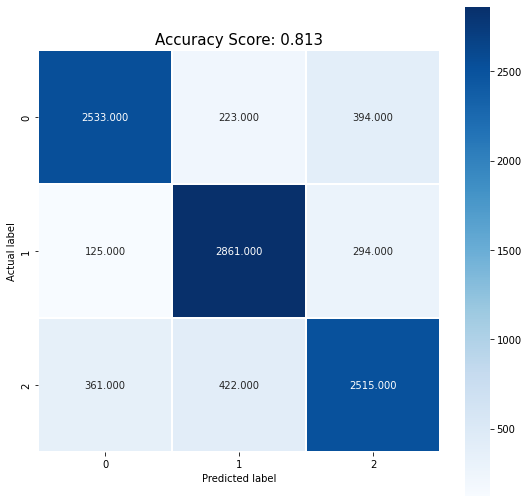

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics


confusion_1 = metrics.confusion_matrix(encoded_list_y_test
, encoded_list_test_pred)

plt.figure(figsize=(9,9))
sns.heatmap(confusion_1, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.3g}'.format(accuracy)
plt.title(all_sample_title, size = 15);

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(encoded_list_y_test, encoded_list_test_pred))

              precision    recall  f1-score   support

           1       0.84      0.80      0.82      3150
           2       0.82      0.87      0.84      3280
           3       0.79      0.76      0.77      3298

    accuracy                           0.81      9728
   macro avg       0.81      0.81      0.81      9728
weighted avg       0.81      0.81      0.81      9728



## Inference on custom sentences

In [ ]:

def check_similarity(sentence1, sentence2):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    pred_prob = model.predict(test_data[0])[0]
    simi_dict = {}
    for i in range(len(pred_prob)):
      simi_dict[labels[i]] = pred_prob[i]
    
    simi_dict = dict(sorted(simi_dict.items()))
    idx = np.argmax(pred_prob)
    max_p = f"{pred_prob[idx]: .2f}%" 
    pred = labels[idx]

    return pred, max_p, simi_dict


Check results on some example sentence pairs.

In [ ]:
sentence1 = "Two women are observing something together."
sentence2 = "Two women are standing with their eyes closed."
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


('entailment',
 ' 0.51%',
 {'contradiction': 0.41733277, 'entailment': 0.510829, 'neutral': 0.07183827})

Check results on some example sentence pairs.

In [ ]:
sentence1 = "A smiling costumed woman is holding an umbrella"
sentence2 = "A happy woman in a fairy costume holds an umbrella"
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


('neutral',
 ' 0.94%',
 {'contradiction': 0.036087893,
  'entailment': 0.022043798,
  'neutral': 0.9418683})

Check results on some example sentence pairs

In [ ]:
sentence1 = "A soccer game with multiple males playing"
sentence2 = "Some men are playing a sport"
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


('entailment',
 ' 0.95%',
 {'contradiction': 0.005167515,
  'entailment': 0.9509257,
  'neutral': 0.04390679})